## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, mean_squared_error, accuracy_score
import seaborn as sns
import datetime as dt
from scipy import stats
from scipy.stats import norm
pd.options.display.float_format = '{:.0f}'.format

## Loading Dataset

In [22]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("DelayedFlights.csv")
df.drop(columns = ['Unnamed: 0', 'Year', 'FlightNum'], inplace = True)
df


,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003,1955,2211,2225,WN,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754,735,1002,1000,WN,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,N,0,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628,620,804,750,WN,N428WN,96,90,76,14,8,IND,BWI,515,3,17,0,N,0,NaN,NaN,NaN,NaN,NaN
3,1,3,4,1829,1755,1959,1925,WN,N464WN,90,90,77,34,34,IND,BWI,515,3,10,0,N,0,2,0,0,0,32
4,1,3,4,1940,1915,2121,2110,WN,N726SW,101,115,87,11,25,IND,JAX,688,4,10,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,13,6,1250,1220,1617,1552,DL,N938DL,147,152,120,25,30,MSP,ATL,906,9,18,0,N,0,3,0,0,0,22
1936754,12,13,6,657,600,904,749,DL,N3743H,127,109,78,75,57,RIC,ATL,481,15,34,0,N,0,0,57,18,0,0
1936755,12,13,6,1007,847,1149,1010,DL,N909DA,162,143,122,99,80,ATL,IAH,689,8,32,0,N,0,1,0,19,0,79
1936756,12,13,6,1251,1240,1446,1437,DL,N646DL,115,117,89,9,11,IAD,ATL,533,13,13,0,N,0,NaN,NaN,NaN,NaN,NaN


In [19]:
df[df['DepDelay'] > 1000]

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
66969,219451,2008,1,6,7,729,1310,1054,1653,UA,47,N664UA,325,343,301,1081,1099,LAX,OGG,2486,3,21,0,N,0,1032,0,0,0,49
117546,386170,2008,1,25,5,729,1215,NaN,1325,MQ,3338,N904AE,NaN,70,NaN,NaN,1154,TYR,DFW,103,NaN,26,0,N,1,NaN,NaN,NaN,NaN,NaN
131293,426476,2008,1,28,1,756,1316,1131,1625,NW,243,N321US,215,189,181,1146,1120,FLL,DTW,1127,11,23,0,N,0,1120,0,26,0,0
133877,435510,2008,1,6,7,1234,1905,1348,2010,NW,678,N778NC,74,65,60,1058,1049,MSP,GRB,252,2,12,0,N,0,0,1049,9,0,0
135757,443080,2008,1,3,4,831,1531,1121,1824,NW,1107,N366NW,170,173,149,1017,1020,RSW,DTW,1085,9,12,0,N,0,1017,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1906664,6932676,2008,12,17,3,1103,1430,1555,1930,AA,1790,N473AA,172,180,147,1225,1233,LAS,STL,1372,5,20,0,N,0,0,1225,0,0,0
1909103,6939485,2008,12,27,6,1125,1405,1434,1715,AA,2228,N624AA,129,130,98,1279,1280,HDN,DFW,769,7,24,0,N,0,993,0,0,0,286
1909125,6939532,2008,12,18,4,903,1325,1000,1430,AA,2241,N5EAAA,117,125,100,1170,1178,DFW,GUC,678,6,11,0,N,0,1170,0,0,0,0
1909638,6940930,2008,12,18,4,1047,1525,1328,1825,AA,2342,N5EAAA,101,120,82,1143,1162,GUC,DFW,678,10,9,0,N,0,0,0,0,0,1143


array([[<AxesSubplot:title={'center':'DepDelay'}>]], dtype=object)

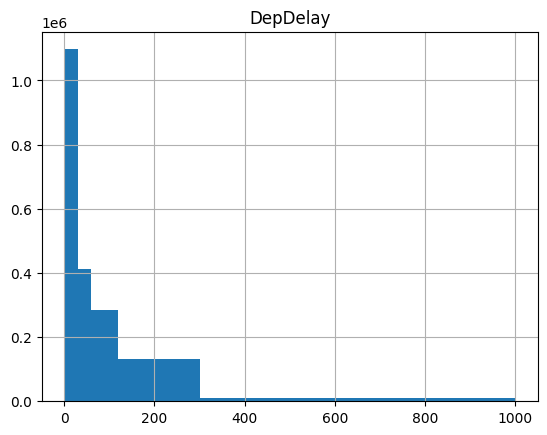

In [23]:
df.hist(column = 'DepDelay', bins = [0, 30, 60, 120, 300, 1000])

In [ ]:
def create_categories(minutes):
    if minutes <= 30:
        return ''
    elif minutes > 30 and minutes <= 60:
        ...
    elif minutes > 60 and minutes <= 150:
        ...
    elif minutes > 150 and minutes <= 300:
        ...
    else:


In [10]:
df["CancellationCode"].value_counts()

N    1936125
B        307
A        246
C         80
Name: CancellationCode, dtype: int64

<AxesSubplot:>

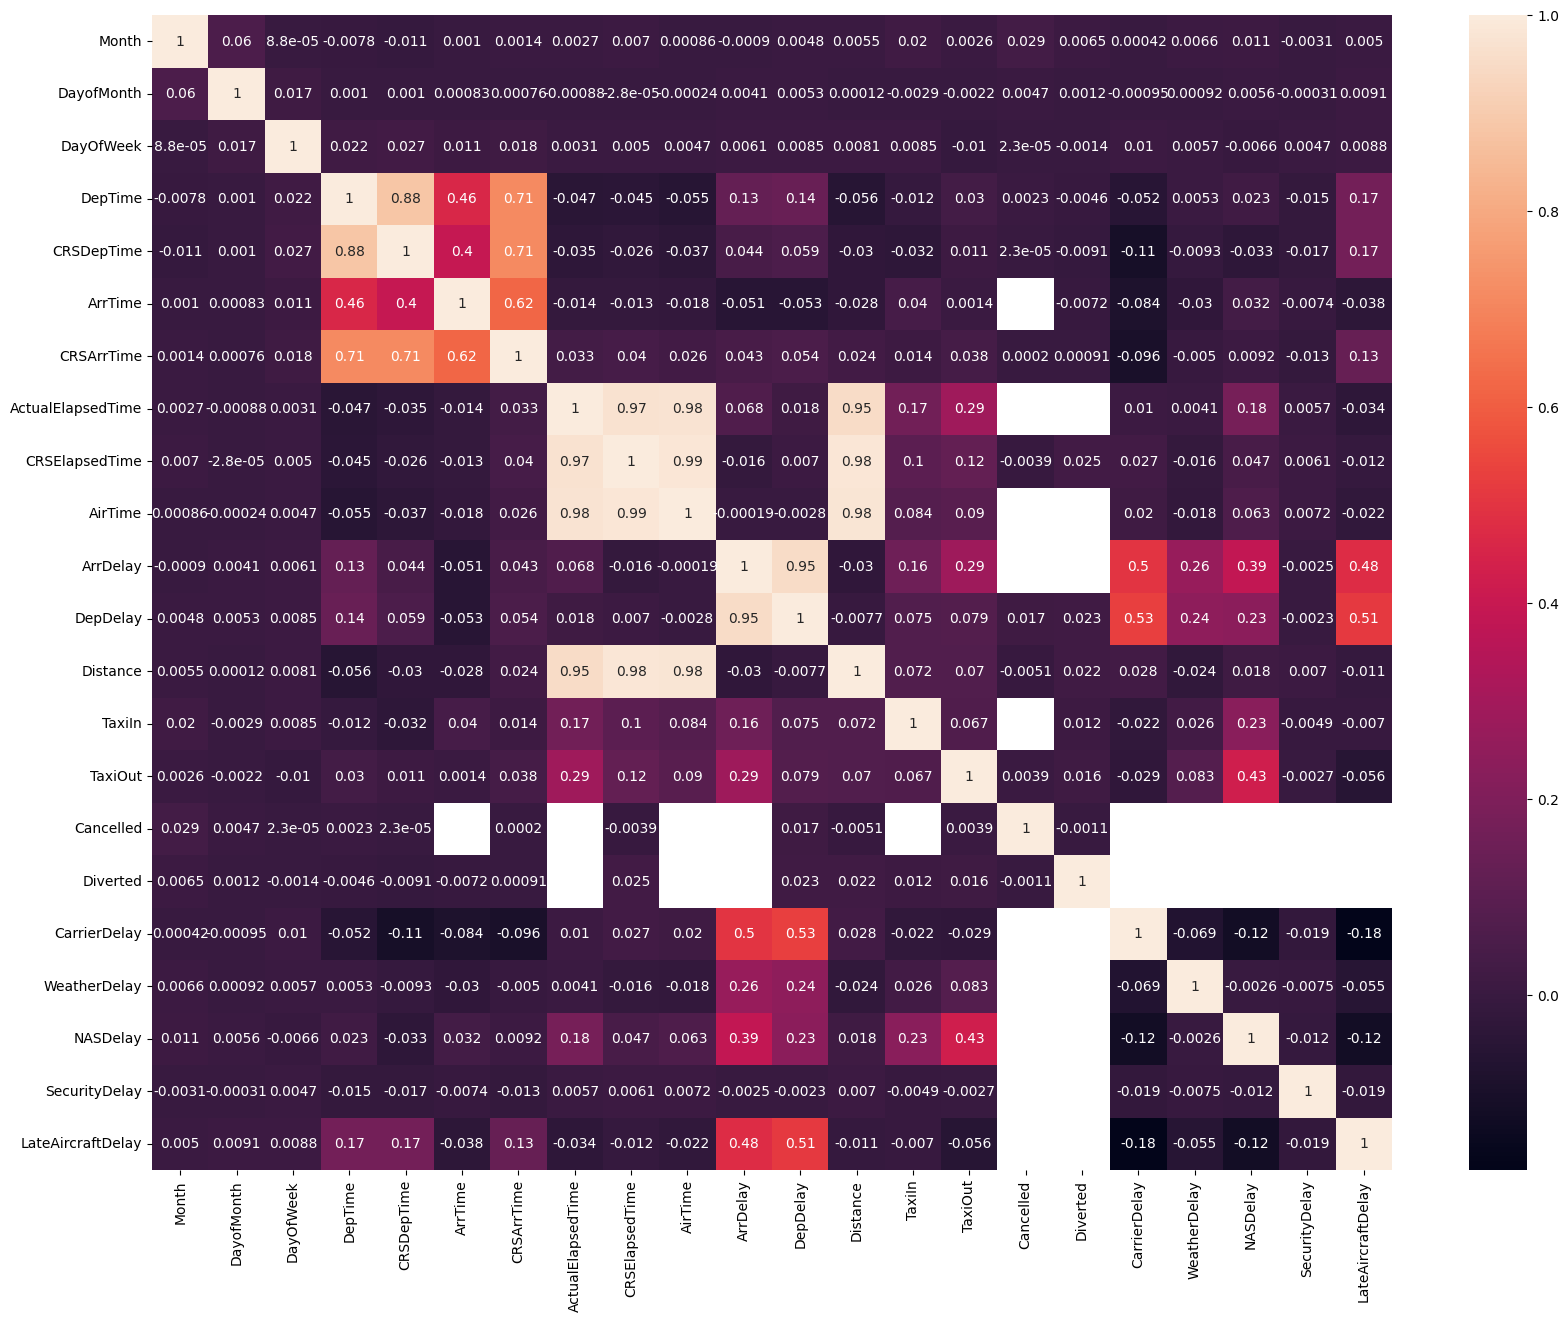

In [5]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 10})